**Self-Assembly of a Dimer System -- Companion Notebook -- October 2018** 


### Table of Contents

**I.** Paramter Space and Phase Plots 

**II.** Numerical Solutions to Equilibrium Conditions 

**III.** Monte Carlo Simulation 

**IV.** Solutions and Simulations Together

In [90]:
%matplotlib inline
import numpy as np
import scipy 
import sklearn
import matplotlib.pyplot as plt
import warnings

from scipy.optimize import *

from scipy import integrate
from sklearn import metrics
from scipy import stats

import scipy

import random
import math
import time
import copy

## shorter definitions
comb = scipy.misc.comb 

def factorial2(n):
    return float(scipy.misc.factorial2(n, exact= True))

def factorial(n):
    return float(scipy.misc.factorial(n, exact= True))

#from numpy import random
from random import shuffle
## loads uniform random sampling 
runif = np.random.rand
from random import randint

from itertools import chain

nquad = scipy.integrate.nquad
quad = scipy.integrate.quad
lambertw = scipy.special.lambertw
simpson = scipy.integrate.simps
trapz = scipy.integrate.trapz

## I. Paramater Space and Phase Plots

Definitions of $T_k$ and $T_m$:

\begin{equation}
k_BT_k = \frac{2}{3}(E_0 + \Delta) \left[W_{0} \left(\frac{4 \pi m_0 (E_0 + \Delta)}{3 h^2} \left(\frac{NV}{4 \sqrt{2}}\right)^{2/3}\right)\right]^{-1}+{\cal O}\left( N^{-1} \right)
\end{equation}

\begin{equation}
k_BT_m = \frac{\Delta}{\ln (2N)} + {\cal O}\left(N^{-1}\right)
\end{equation}

In [2]:
## definitions of temperature Tk and Tm

def kbTvec(E0, Del, Ev, N):
    
    En = E0 + Del
    
    Tk = (2*En/3)/lambertw(4*En/(3*Ev)*(N/(4*np.sqrt(2)))**(2/3)).real
    
    Tm = Del/np.log(2*N)
    
    return Tk, Tm

In [3]:
## Defines the phase given the temperature of the system and the parameters
'''
0.0 is the completely dimerized and fully correct phase
1.0 is the completely dimerized and partially correct phase
2.0 is the partially dimerized and partially correct phase of Type I
3.0 is the partially dimerized and partially correct phase of Type II
'''

def phase_assoc(E0, Del, Ev, N, T):
    
    # k and m temperatures
    Tk = kbTvec(E0, Del, Ev, N)[0]
    Tm = kbTvec(E0, Del, Ev, N)[1]
    
    if T < Tk and T < Tm:
        return int(0.0)
    elif Tm < T < Tk: 
        return int(1.0)
    elif Tk < T  < Tm or Tk < Tm < T: 
        return int(2.0)
    elif Tm < Tk < T:
        return int(3.0)

In order to plot the phase behavior of this system defined by various coordinate axes, we need to translate the three conditions $T= T_m$, $T= T_k$, and $T_m = T_k$ into their corresponding forms for the respective axes. 

----

### $\beta E_0$-$\beta \Delta$ phase plot

- Boundary Lines
    - $T = T_m$ condition: $\beta \Delta = \ln (2N)$
    - $T = T_k$ condition: $\displaystyle \beta \Delta = - \beta E_0 + \ln \left[ \frac{N}{4 \sqrt{2}} \frac{1}{(\beta E_V)^{3/2}}\right]$
    - $T_k = T_m$ condition: $\displaystyle \beta \Delta = - \frac{2\beta E_0}{3} \ln (2N) \left[W_{0}\left( \frac{2E_0}{3 E_v} \frac{1}{(8 \sqrt{2})^{2/3}}\right) \right]^{-1}$

where $E_V = h^2/2\pi m_0 V^{2/3}$

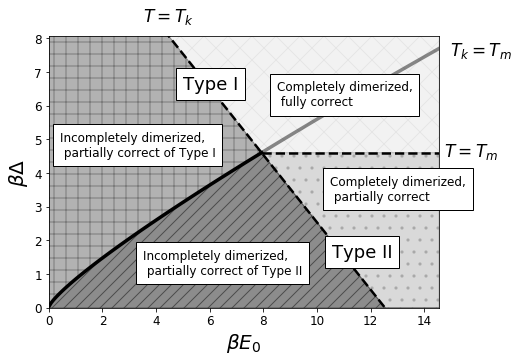

In [4]:
## phase plot in beta E0 and beta delta space

# parameter choices
Ev = 10**(-3)
Nelem = 50
Temp = 1.0
# paramater bounds
E0_max = 14.55
Del_max = 8.05

# plot size
plt.figure(figsize = (7,5))

# functional form of T=Tk constraint as a function of E0 or Delta
Tkline = lambda E0, Ev, N: - E0 + (1.5)*np.log(1.0/Ev*(N/(4*np.sqrt(2)))**(2/3))

# functional form of Tk=Tm constraint
TkTmline = lambda E0,Ev, N: (2*np.log(2*N)*E0/3)/(lambertw((2/3)*E0/(8*np.sqrt(2))**(2/3)/Ev).real)

# E0 value at which boundary lines intersect
E0cut = Tkline(np.log(2*Nelem), Ev/Temp, Nelem )

# Beta E values
betaE = np.linspace(0.01, E0_max/Temp, 100) # full spectrum of energy values
betaE_cut = np.linspace(0.01,E0cut/Temp, 100) # spectrum of energy up to cut
betaE_cut2 = np.linspace(E0cut/Temp, E0_max/Temp, 100) # spectrum of energy after cut
betaE_200= np.concatenate([betaE_cut, betaE_cut2]) #concatenation of cut energies

# phase bondary plots
plt.plot(betaE, Tkline(betaE,Ev/Temp, Nelem ), color = 'k', linestyle='--', linewidth = 2.50)
plt.plot(betaE_cut, TkTmline(betaE_cut, Ev/Temp, Nelem ), color = 'k', linestyle='solid', linewidth = 3.50)
plt.plot(betaE_cut2, TkTmline(betaE_cut2, Ev/Temp, Nelem ), color = 'k', linestyle='solid', linewidth = 3.50, alpha = 0.45)
plt.plot( [E0cut, E0_max/Temp] ,[np.log(2*Nelem), np.log(2*Nelem)], 'k--', linewidth = 2.50)

# Concatenation for incompletely dimerized and partially correct Type II
concat1 = np.concatenate([TkTmline(betaE_cut, Ev/Temp, Nelem ),Tkline(betaE_cut2, Ev/Temp, Nelem )])

# Concatenation for completely dimerized and fully correct
concat2 = np.concatenate([Tkline(betaE_cut, Ev/Temp, Nelem ), np.log(2*Nelem)*np.ones(100)])

# fill in between lines
plt.fill_between(betaE_cut ,TkTmline(betaE_cut, Ev/Temp, Nelem ) ,Tkline(betaE_cut, Ev/Temp, Nelem ) , color='xkcd:black', hatch='+', alpha='0.3')
plt.fill_between(betaE_cut2  ,Tkline(betaE_cut2, Ev/Temp, Nelem ) , np.log(2*Nelem), color='xkcd:black', hatch='.', alpha='0.15')
plt.fill_between(betaE_200  , 0, concat1, color='xkcd:black', hatch='//', alpha='0.45')
plt.fill_between(betaE_200  ,  concat2, 12, color = 'xkcd:black', hatch = 'x', alpha='0.05')

# axis labels
plt.xlabel(r'$\beta E_0$', fontsize = 20)
plt.ylabel(r'$\beta \Delta$', fontsize = 20)

ax = plt.gca()

# Legend Boxes for the phases and types
ax.text(8.5, 6.0, 'Completely dimerized,\n fully correct', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10.5, 3.2, 'Completely dimerized,\n partially correct', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(0.4, 4.5, 'Incompletely dimerized,\n partially correct of Type I', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(3.5, 1.0, 'Incompletely dimerized,\n partially correct of Type II', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10.55, 1.5, 'Type II', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(5.0, 6.5, 'Type I', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(3.5, 8.5, r'$T = T_k$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.text(14.75, np.log(2*Nelem)-.1, r'$T = T_m$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.text(14.95, 7.5, r'$T_k = T_m$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))


ax.set_xlim([0,(E0_max)/Temp+.02])
ax.set_ylim([0,(Del_max)/Temp+.02])

plt.tick_params(axis='both', which='major', labelsize=12)


plt.show()

-----

-----

### $\beta \Delta$-$n\lambda_0^3$ phase plot

- Boundary Lines
    - $T = T_m$ condition: $\beta \Delta = \ln (2N)$
    - $T = T_k$ condition: $\beta \Delta = - \beta E_0 + \ln (N^2) - \ln (4\sqrt{2} n\lambda_0^3)$
    - $T_k = T_m$ condition: $\displaystyle \beta \Delta = \frac{\beta E_0 \ln (2N)}{\ln (N) - \ln (8 \sqrt{2} n\lambda_0^3)}$

where $n = N/V$, $E_V = h^2/2\pi m_0 V^{2/3}$, and $\lambda_{0}^3/V = (\beta E_V)^{3/2}$

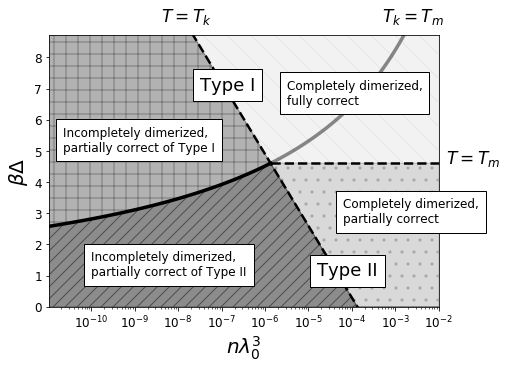

In [5]:
## phase plot in beta Delta and nlam^3 space

# parameter choices
E0 = 15.00
Del_max = 8.70
Nelem = 50
Temp = 1.0
# paramater bounds
logdenslam3max = -2
logdenslam3min = -11


# figure size
plt.figure(figsize = (7,5))

# functional form of Tk constraint
Tkline_2 = lambda denslam3, E0, Nelem: -E0 + np.log(Nelem**2)- np.log(4*np.sqrt(2)*denslam3)

# funcitional form of Tk = Tm constraint
TkTmline_2 = lambda denslam3, E0, Nelem: E0*np.log(2*Nelem)/(np.log(Nelem)- np.log(8*np.sqrt(2)*denslam3))

# density value where boundary lines intersect
dens_start = lambda E0, Del, Nelem: Nelem**2/(4*np.sqrt(2))*np.exp(-(E0+ Del))

# denslam^3 values
dens_cut = dens_start(E0, np.log(2*Nelem), Nelem) # value at which concatenation happens
denslam3 = np.logspace(logdenslam3min, logdenslam3max, 100)
denslam3_cut = np.logspace(logdenslam3min, np.log10(dens_cut), 100)
denslam3_2cut = np.logspace(np.log10(dens_cut), logdenslam3max, 100)
denslam3_200 = np.concatenate([denslam3_cut,denslam3_2cut])

# plots 
plt.semilogx(denslam3, Tkline_2(denslam3,E0,Nelem ), color = 'k', linestyle='--', linewidth = 2.50)
plt.semilogx(denslam3_cut, TkTmline_2(denslam3_cut,E0,Nelem ), color = 'k', linestyle='solid', linewidth = 3.5)
plt.semilogx(denslam3_2cut, TkTmline_2(denslam3_2cut,E0,Nelem ), color = 'k', linestyle='solid', linewidth = 3.5, alpha = 0.45)
plt.semilogx( [dens_cut,10**(logdenslam3max) ],[np.log(2*Nelem),np.log(2*Nelem) ] , 'k--', linewidth = 2.50)

# Concatenation for incompletely dimerized and partially correct of Type II
concat1_denslam3 = np.concatenate([TkTmline_2(denslam3_cut,E0,Nelem ),Tkline_2(denslam3_2cut,E0,Nelem )])

# Concatenation for completely dimerzied and fully correct 
concat2_denslam3 = np.concatenate([Tkline_2(denslam3_cut,E0,Nelem ),np.ones(100)*np.log(2*Nelem)])

# fill in between boundary lines
plt.fill_between(denslam3_cut ,TkTmline_2(denslam3_cut,E0,Nelem ) ,Tkline_2(denslam3_cut,E0,Nelem ) , color='xkcd:black', hatch='+',alpha='0.3')
plt.fill_between(denslam3_2cut ,Tkline_2(denslam3_2cut,E0,Nelem ) , np.log(2*Nelem), color='xkcd:black',hatch='.', alpha='0.15')
plt.fill_between(denslam3_200 , 0, concat1_denslam3, color='xkcd:black', hatch='//',alpha='0.45')
plt.fill_between(denslam3_200 ,  concat2_denslam3, 12, color='xkcd:black', hatch='\\',alpha='0.05')


# axis labels
plt.xlabel(r'$n\lambda_0^3$', fontsize = 20)
plt.ylabel(r'$\beta \Delta$', fontsize = 20)

ax = plt.gca()

# Legend Boxes for the phases and types
ax.text(10**(-5.5), 6.5, 'Completely dimerized,\nfully correct', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-4.2), 2.7, 'Completely dimerized,\npartially correct', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-10.65), 5.0, 'Incompletely dimerized,\npartially correct of Type I', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-10), 1.0, 'Incompletely dimerized,\npartially correct of Type II', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-4.8), 1.0, 'Type II', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-7.5), 6.95, 'Type I', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-8.4), 9.15, r'$T = T_k$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.text(1.5*10**(-2), np.log(2*Nelem), r'$T = T_m$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.text(10**(-3.3), 9.15, r'$T_k = T_m$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.set_xlim([10**(logdenslam3min)*(1.05),10**(logdenslam3max)*(1.05)])
ax.set_ylim([0,(Del_max)/Temp+.02])

plt.tick_params(axis='both', which='major', labelsize=12)
    
#plt.savefig("./delta_denslam3_phaseplot_new.png", bbox_inches='tight')
    
plt.show()

-----

-----

### $2N$-$\lambda_0^3/V$ phase plot

-  Boundary lines
    - $T = T_m$ condition: $2N = e^{\beta \Delta}$
    - $T = T_k$ condition: $\displaystyle 2N = \frac{8 \sqrt{2}\lambda_0^3}{V} e^{\beta (E_0 + \Delta)}$
    - $T_k = T_m$ condition: $\displaystyle 2N = \left( \frac{V}{8 \sqrt{2} \lambda_0^3} \right)^{\Delta/E_0}$
    
where $n = N/V$, $E_V = h^2/2\pi m_0 V^{2/3}$, and $\lambda_{0}^3/V = (\beta E_V)^{3/2}$

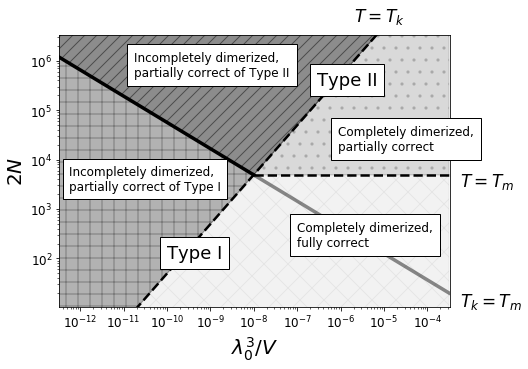

In [8]:
## phase plot in 2N and lam^3/V space

# paramater choices
E0 = 16.00
Del = 8.5
Temp = 1.0
# Parameter bounds
logNmax = 6.5
logNmin = 1
loglam3Vmax = -3.5
loglam3Vmin = -12.5

# figure size
plt.figure(figsize = (7,5))

# functional form of Tk constraint
Tkline_3 = lambda lam3V, E0, Del: 8*np.sqrt(2)*(lam3V)*np.exp((E0+Del))

# funcitional form of Tk = Tm constraint
TkTmline_3 = lambda lam3V, E0, Del: (1.0/(8*np.sqrt(2)*(lam3V)))**(Del/E0)

# lambda_0^3/ V where constraints intersect
lam3V_end = lambda E0: np.exp(-E0)/(8*np.sqrt(2))

# lambda^3/V values
lam3V = np.logspace(loglam3Vmin, loglam3Vmax, 100)
lam3V_cut = np.logspace(loglam3Vmin,np.log10(lam3V_end(E0)), 100)
lam3V_cut2 = np.logspace( np.log10(lam3V_end(E0)),loglam3Vmax, 100)
lam3V_200 = np.concatenate([lam3V_cut,lam3V_cut2])

# plots of phase boundary lines
plt.loglog(lam3V, Tkline_3(lam3V,E0, Del ), color = 'k', linestyle='--', linewidth = 2.50)
plt.loglog(lam3V_cut, TkTmline_3(lam3V_cut,E0, Del ), color = 'k', linestyle='solid', linewidth = 3.5)
plt.loglog(lam3V_cut2, TkTmline_3(lam3V_cut2,E0, Del ), color = 'k', linestyle='solid', linewidth = 3.5, alpha = 0.45)
plt.loglog( [lam3V_end(E0),np.exp(loglam3Vmax) ] ,[np.exp(Del), np.exp(Del)], 'k--', linewidth = 2.50)

# Concatenation for incompletely dimerized and partially correct Type II
concat1_lam3V = np.concatenate([TkTmline_3(lam3V_cut,E0, Del ),Tkline_3(lam3V_cut2, E0, Del)])

# Concatenation for completely dimerized and fully correct
concat2_lam3V = np.concatenate([Tkline_3(lam3V_cut,E0, Del ),np.ones(100)*np.exp(Del)])

# fill in between boundary lines
plt.fill_between(lam3V_cut  ,Tkline_3(lam3V_cut,E0, Del),TkTmline_3(lam3V_cut,E0, Del) , color='xkcd:black', hatch='+', alpha='0.3')
plt.fill_between(lam3V_cut2 , np.exp(Del), Tkline_3(lam3V_cut2,E0, Del), color='xkcd:black', hatch='.', alpha='0.15')
plt.fill_between(lam3V_200 , concat1_lam3V, 5.0*10**8, color='xkcd:black', hatch='//', alpha='0.45')
plt.fill_between(lam3V_200 , 5, concat2_lam3V, color='xkcd:black',hatch = 'x', alpha='0.05')

# axis labels
plt.xlabel(r'$\lambda_0^3/V$', fontsize = 20)
plt.ylabel(r'$2N$', fontsize = 20)

ax = plt.gca()

# Legend Boxes for the phases and types
ax.text(10**(-7), 10**(2.25), 'Completely dimerized,\nfully correct', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-6.05), 10**4.2, 'Completely dimerized,\npartially correct', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-12.25), 10**3.375, 'Incompletely dimerized,\npartially correct of Type I', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=6.0))

ax.text(10**(-10.75), 10**5.7, 'Incompletely dimerized,\npartially correct of Type II', color='black', fontsize = 12,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-6.55), 10**5.50, 'Type II', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-10), 10**2, 'Type I', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='black', pad=7.0))

ax.text(10**(-5.7), 10**6.8, r'$T = T_k$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.text(10**(-3.25), np.exp(Del-0.51), r'$T = T_m$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

ax.text(10**(-3.25), 11.0, r'$T_k = T_m$', color='black', fontsize = 17,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

# axis limits
ax.set_xlim([10**(loglam3Vmin)*(1.05),10**(loglam3Vmax)*(1.05)])
ax.set_ylim([10**(logNmin)*(1.05),10**(logNmax)*(1.05)])

plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.show()

## II. Numerical Solution to Equilibrium Conditions 

We seek to numerically solve the equilibrium conditions 

\begin{equation}
\frac{e^{\beta \Delta}}{2} = \langle m \rangle \frac{N-\langle m \rangle(1- e^{-\beta \Delta})}{\langle k \rangle - \langle m \rangle(1- e^{-\beta \Delta})}, \qquad  \frac{4\sqrt{2}\,\lambda_0^3}{V}\,e^{\beta E_0} = \frac{\langle k \rangle - \langle m \rangle(1- e^{-\beta \Delta})}{\big(N - \langle k \rangle\big)^2}
\end{equation}

and to display the resulting phase behavior in $\beta\Delta$-$\beta E_0$, $2N$-$\lambda_0^3/V$, and $\beta\Delta$-$n \lambda_0^3$ space (where $n = N/V$). 

In what follows we define 
\begin{equation}
E_V = \frac{h^2}{2\pi m_0 V^{2/3}},
\end{equation}
as the kinetic energy scale of a single unit. $E_0$ is the binding energy of an incorrect dimer and $\Delta$ is the binding energy advantage of a correct dimer. 

#### Equation solver, Standard deviation definition, $T_k$ and $T_m$ definition

In [9]:
### equation solver for the system of equations of state

def myfunc(z, T, E0,Del, Ev, N):
    
    m = z[0]
    k = z[1]
    
    F = np.ones(2)

    F[0]=  m*(N-m*(1-np.exp(-Del/T))) - np.exp(Del/T)*(k-m*(1-np.exp(-Del/T)))/2
    F[1] =  (k-m*(1-np.exp(-Del/T))) - 4*np.sqrt(2)*np.exp(E0/T)*(Ev/T)**(3/2)*(N-k)**2
      
    return F

## testing values 
E0 =1.0
Del = .05
Ev = 0.001
Nelem = 50
fsolve(myfunc, [.05, 1.0], args = (.7, E0, Del, Ev, Nelem))

array([ 0.03045014,  2.83707918])

In [10]:
# variances and covariances

def sigma_k(k, N):
    
    return np.sqrt(1.0/(2*N)*k*(N-k))

def sigma_m(k, m, N): 
    
    return np.sqrt(m - m**2/2*(1/k + 1/N))

In [11]:
## definition of critical temperature  Tk

def kbTk(E0,Del, Ev, N):
    
    En = E0 + Del
    
    return (2*En/3)/lambertw(4*En/(3*Ev)*(N/(4*np.sqrt(2)))**(2/3))

# definition of critical temperature Tm

def kbTm(Del, N):
    
    return Del/np.log(2*N)

#### Plots of solutions to equation solver

#### (b)  Type I 

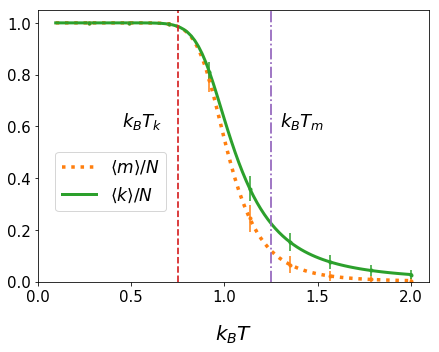

kBT_k = 0.7526113728
kBT_m = 1.24859663547


In [13]:
## Plot of a <k> and <m> for a Type I dimer system

plt.figure(figsize = (7,5))

# physical parameters
E0 =4.15
Del =5.75
Ev = 10**(-3)
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0


# spectrum of temperature values; empty vectors for means
temp_vals = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals))
mvals = np.ones(len(temp_vals))

# generating values of k and m means
for k in range(len(temp_vals)):
    mvals[k], kvals[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals[k], E0,Del, Ev, Nelem))


#plot of k and m versus T; means 
plt.plot(temp_vals[2:], mvals[2:]/Nelem, color = 'C1', linestyle='dotted', label = r'$\langle m \rangle/N$', linewidth = 3.5)
plt.plot(temp_vals[2:], kvals[2:]/Nelem, color = 'C2', linestyle='solid', label = r'$\langle k \rangle/N$', linewidth = 3.0)
    
# spectrum of temperature values; empty vectors for standard deviations
temp_vals_err = np.linspace(Tmin, Tmax, 10)
kvals_err = np.ones(len(temp_vals_err))
mvals_err = np.ones(len(temp_vals_err))

# generating values of k and m standard deviations
for k in range(len(temp_vals_err)):
    mvals_err[k], kvals_err[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals_err[k], E0,Del, Ev, Nelem))

#plot of k and m versus T; standard deviations
plt.errorbar(temp_vals_err[1:], mvals_err[1:]/Nelem, color = 'C1', fmt = '.', yerr = sigma_m(kvals_err[1:], mvals_err[1:], Nelem)/Nelem)
plt.errorbar(temp_vals_err[1:], kvals_err[1:]/Nelem, color = 'C2', fmt = '.', yerr = sigma_k(kvals_err[1:], Nelem)/Nelem)

# plot of critical temperatures
plt.axvline(x= kbTk(E0, Del, Ev, Nelem).real, color = 'C3', linestyle='dashed', linewidth = 1.75)
plt.axvline(x= Del/np.log(2*Nelem), color = 'C4', linestyle='-.', linewidth = 1.75)


# path design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)

ax.text(0.45, 0.6, r'$k_BT_k$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))
ax.text(1.3, 0.6, r'$k_BT_m$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (.35,0.51), fontsize = 17)

warnings.simplefilter("ignore")

plt.show()

#temperatures T_k and T_m 
print("kBT_k =", kbTk(E0, Del, Ev, Nelem).real)
print("kBT_m =",Del/np.log(2*Nelem))

#### (b) Edge of Type I and Type II systems

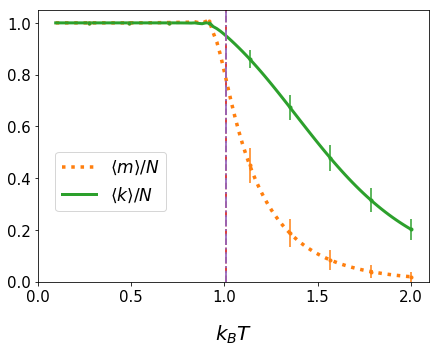

kBT_k = 1.00792044435
kBT_m = 1.00973467043


In [15]:
##  Plot of a <k> and <m> for system intermediate between Types I and II dimer system

plt.figure(figsize = (7,5))

# physical parameters
E0 =9.05
Del =4.65
Ev = 10**(-3)
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0


# spectrum of temperature values; empty vectors for means
temp_vals = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals))
mvals = np.ones(len(temp_vals))

# generating values of k and m means
for k in range(len(temp_vals)):
    mvals[k], kvals[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals[k], E0,Del, Ev, Nelem))


#plot of k and m versus T; means 
plt.plot(temp_vals[2:], mvals[2:]/Nelem, color = 'C1', linestyle='dotted', label = r'$\langle m \rangle/N$', linewidth = 3.5)
plt.plot(temp_vals[2:], kvals[2:]/Nelem, color = 'C2', linestyle='solid', label = r'$\langle k \rangle/N$', linewidth = 3.0)
    
# spectrum of temperature values; empty vectors for standard deviations
temp_vals_err = np.linspace(Tmin, Tmax, 10)
kvals_err = np.ones(len(temp_vals_err))
mvals_err = np.ones(len(temp_vals_err))

# generating values of k and m standard deviations
for k in range(len(temp_vals_err)):
    mvals_err[k], kvals_err[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals_err[k], E0,Del, Ev, Nelem))

#plot of k and m versus T; standard deviations
plt.errorbar(temp_vals_err[1:], mvals_err[1:]/Nelem, color = 'C1', fmt = '.', yerr = sigma_m(kvals_err[1:], mvals_err[1:], Nelem)/Nelem)
plt.errorbar(temp_vals_err[1:], kvals_err[1:]/Nelem, color = 'C2', fmt = '.', yerr = sigma_k(kvals_err[1:], Nelem)/Nelem)

# plot of critical temperatures
plt.axvline(x= kbTk(E0, Del, Ev, Nelem).real, color = 'C3', linestyle='dashed', linewidth = 1.75)
plt.axvline(x= Del/np.log(2*Nelem), color = 'C4', linestyle='-.', linewidth = 1.75)


# path design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.xticks([0.00, 0.25, 0.50, kbTk(E0, Del, Ev, Nelem),1.0, Del/np.log(2*Nelem), 1.50, 1.75, 2.00, 2.25, 2.5], [0.0,'' ,.5 , r'$ k_BT_k$', 1.0, r'$ k_BT_m$', 1.5 ,'' ,'2.0', '', '2.5' ], fontsize = 15)
plt.legend(bbox_to_anchor = (.35,0.51), fontsize = 17)

warnings.simplefilter("ignore")

plt.show()

#temperatures T_k and T_m 
print("kBT_k =", kbTk(E0, Del, Ev, Nelem).real)
print("kBT_m =",Del/np.log(2*Nelem))

#### (c) Type II systems

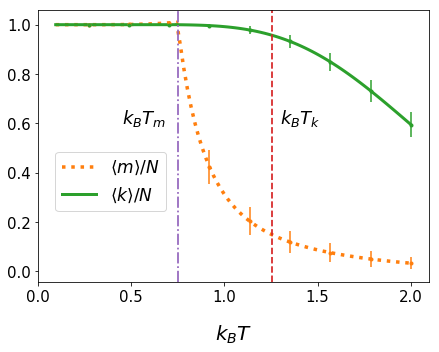

kBT_k = 1.25363030807
kBT_m = 0.749157981283


In [69]:
## Plot of a <k> and <m> for a Type II dimer system

plt.figure(figsize = (7,5))

# physical parameters
E0 =14.00
Del = 3.45
Ev = 10**(-3)
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0


# spectrum of temperature values; empty vectors for means
temp_vals = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals))
mvals = np.ones(len(temp_vals))

# generating values of k and m means
for k in range(len(temp_vals)):
    mvals[k], kvals[k]  = fsolve(myfunc, [0.5, 0.5], args = (temp_vals[k], E0,Del, Ev, Nelem))


#plot of k and m versus T; means 
plt.plot(temp_vals[2:], mvals[2:]/Nelem, color = 'C1', linestyle='dotted', label = r'$\langle m \rangle/N$', linewidth = 3.5)
plt.plot(temp_vals[2:], kvals[2:]/Nelem, color = 'C2', linestyle='solid', label = r'$\langle k \rangle/N$', linewidth = 3.0)
    
# spectrum of temperature values; empty vectors for standard deviations
temp_vals_err = np.linspace(Tmin, Tmax, 10)
kvals_err = np.ones(len(temp_vals_err))
mvals_err = np.ones(len(temp_vals_err))

# generating values of k and m standard deviations
for k in range(len(temp_vals_err)):
    mvals_err[k], kvals_err[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals_err[k], E0,Del, Ev, Nelem))

#plot of k and m versus T; standard deviations
plt.errorbar(temp_vals_err[1:], mvals_err[1:]/Nelem, color = 'C1', fmt = '.', yerr = sigma_m(kvals_err[1:], mvals_err[1:], Nelem)/Nelem)
plt.errorbar(temp_vals_err[1:], kvals_err[1:]/Nelem, color = 'C2', fmt = '.', yerr = sigma_k(kvals_err[1:], Nelem)/Nelem)

# plot of critical temperatures
plt.axvline(x= kbTk(E0, Del, Ev, Nelem).real, color = 'C3', linestyle='dashed', linewidth = 1.75)
plt.axvline(x= Del/np.log(2*Nelem), color = 'C4', linestyle='-.', linewidth = 1.75)

# path design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
#ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)

ax.text(0.45, 0.6, r'$k_BT_m$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))
ax.text(1.3, 0.6, r'$k_BT_k$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (.35,.51), fontsize = 17)

warnings.simplefilter("ignore")


plt.show()

#temperatures T_k and T_m 
print("kBT_k =", kbTk(E0, Del, Ev, Nelem).real)
print("kBT_m =",Del/np.log(2*Nelem))

### Phase Diagrams for System 

## III. Monte Carlo Simulations 

Quoted from paper

"The simulation results in \reffig{typeIandII} were obtained using the Metropolis-Hastings Monte Carlo algorithm. We defined the microstate of our system by two lists: One defining the particles which were monomers and the other defining the monomer-monomer pairs making up the dimers. For example, a $2N = 10$ particle system, could have a microstate defined by the monomer list $[1,4,6,9]$ and the dimer list $[(3,5), (2,8), (7, 10)]$. The free energy of a microstate was given by $f = - k E_0 - m \Delta - k\,k_BT\ln (V/\lambda_0^3) - (2N-2k)k_BT \ln(2 \sqrt{2}\, V/\lambda_0^3)$ for a system with $k$ dimers of which $m$ consisted of correct contacts. 

To efficiently explore the state space of the system, we used three different types of transitions with unique probability weights for each one. In the following list $N_{\text{m}}$ and $N_{\text{d}}$ represent, respectively, the lengths of the monomer and dimer lists before the transition. 

- **Monomer Association:** Two randomly chosen monomers are removed from the monomer list, joined as a pair, and the pair is appended to the dimer vector.  Weight = $\binom{N_{\text{m}}}{2}/(N_{\text{d}}+1)$ <br> *Example:* mon = $[1,3, 4, 5, 6,9]$ and dim = $[(2,8), (7, 10)]$ $\to$ mon = $[1,4,6,9]$ and\\ dim = $[(3,5), (2,8), (7, 10)]$; Weight = 15/3.


- **Dimer Dissociation:** One randomly chosen dimer is removed from the dimer vector, and both of its elements are appended to the monomer vectors. Weight = $ N_{\text{d}}/\binom{N_{\text{m}}+2}{2}$ <br> *Example:* mon = $[6,9]$ and dim = $[ (1, 4), (3,5), (2,8), (7, 10)]$ $\to$ mon = $[2, 6,8, 9]$ and\\ dim = $[ (1, 4), (3,5), (7, 10)]$; Weight = 4/6.

- **Dimer Cross-Over:** Two randomly chosen dimers each have a randomly chosen component switched with the respective randomly chosen component of the other dimer.  Weight =1.  <br>*Example:* dim = $[ (1, 4), (3,5) (7, 10) ]$ $\to$ dim = $[ (1, 10), (3,5), (4, 10)]$  ]; Weight = 1.

The third type of transition is unphysical but is necessary to ensure that the system can quickly escape kinetic traps that led to inefficient sampling of the state space. 

For each simulation step, there was a 1/3 probability of selecting each transition type and the suggested step was accepted with log-probability 

$$
\ln p_{\text{accept}} = -  (f_{\text{fin.}}-f_{\text{init.}})/k_BT+\ln\text{(Weight)}, 
$$ <br>

where $f_{\text{fin}}$ and $f_{\text{init}}$ are the final and initial free energies of the microstate, and "(Weight)" is the ratio between the number of ways to make the forward transition and the number of ways to make the reverse transition. This weight was chosen for each transition type to ensure that detailed balance was maintained. For impossible transitions (e.g., monomer association for a microstate with no monomers), $p_{\text{accept}}$ was set to zero. 


#### Preliminary Functions

In [113]:
## randomly selects two elements (w/o replacement) from list

def rand_select(ls):
    
    lss = copy.deepcopy(ls)
    
    elem = random.choice(lss)
    
    lss.remove(elem)
    
    elem2 = random.choice(lss)
    
    return [elem, elem2]

In [114]:
## counts number of correct dimers in a list of dimers

def count_corr(dim_state, Np):
    
    # generates list of correct dimers; for monomers in both orders
    corr_list = [0]*(2*Np)
    for k in range(Np):
        corr_list[k] = [k+1,Np+k+1]
        corr_list[k+Np] = [Np+k+1, k+1]

    count = 0
    for j in range(len(dim_state)):
        if dim_state[j] in corr_list:
            count = count+1
            
    return count

In [115]:
## First type of transition; Monomer Association

def trans_state1(mon_state, dim_state):
    
    # copies monomer and dimer lists; must use deep copy otherwise lists change
    monomers = copy.deepcopy(mon_state)
    dimers = copy.deepcopy(dim_state)
    
    # selects random monomers and removes them from list
    mon1, mon2 = rand_select(monomers)

    # removes the selected monomers
    monomers.remove(mon1)
    monomers.remove(mon2)

    # turns the monomers into dimers and appends them to dimer state
    dimers.append([mon1, mon2])
    
    return [monomers, dimers]

In [116]:
## Second type of transition; Dimer dissociation

def trans_state2(mon_state, dim_state):
    
    # copies monomer and dimer lists; must use deep copy otherwise lists change
    monomers = copy.deepcopy(mon_state)
    dimers = copy.deepcopy(dim_state) 

    # selected dimer
    dim1 = random.choice(dimers)

    # removes selected dimer
    dimers.remove(dim1)

    # selects monomers from the dimers 
    mon1, mon2 = dim1

    # adds selected monomers to monomer list
    monomers.append(mon1)
    monomers.append(mon2)
    
    
    return [monomers, dimers]

In [117]:
## Third type of transition; Switching elements of Dimer

def trans_state3(mon_state, dim_state):
    
    # copies monomer and dimer lists; must use deep copy otherwise lists change
    monomers = copy.deepcopy(mon_state)
    dimers = copy.deepcopy(dim_state)

    dim1, dim2 = rand_select(dimers) #randomly chosen dimer pair

    # removes dimer pair from list of dimers
    dimers.remove(dim1)
    dimers.remove(dim2)
    
    i1 = randint(0,1) #random index 1
    i2 = randint(0,1) #random index 2

    mon1 = dim1[i1] #randomly chosen element of first dimer 
    mon2 = dim2[i2] #randomly chosen element of second dimer

    # switch randomly chosen elements of dimers
    dim1[i1] = mon2 
    dim2[i2] = mon1

    # appends new dimers 
    dimers.append(dim1)
    dimers.append(dim2) 
    
    return [monomers, dimers]

In [102]:
## Third type of transition; Switching elements of Dimer

def trans_state3(mon_state, dim_state):
    
    # copies monomer and dimer lists; must use deep copy otherwise lists change
    monomers = copy.deepcopy(mon_state)
    dimers = copy.deepcopy(dim_state)

    dimers_list = list(chain.from_iterable(dimers))
    
    twoN = len(dimers_list)

    i1 = int(random.choice(range(twoN)))
    i2 = int(random.choice(range(twoN)))

    ## new omega vector 
    fin_ls = copy.deepcopy(dimers_list)
    fin_ls[i2] = dimers_list[i1]
    fin_ls[i1] = dimers_list[i2]
    
    dimers_final = [[fin_ls[i],fin_ls[i+1]] for i in range(int(len(fin_ls)/2))]
    
    return [monomers, dimers_final]

In [118]:
# computes the free energy of the microstate; we only need the number of particles
# and the dimer state to compute this energy

def energy(Np, dim_state, temp, E0, Delta, Ev):
    ''' Npar: number of particles
    dim_state: dimer state
    temp: temperature of system
    E0: offset binding energy
    Delta: energy advantage
    Ev: energy by de Broglie wavelength '''
    
    k = len(dim_state) #number of dimers in system
    m = count_corr(dim_state, Np) # number of correct dimers in system
    
    # Inverse of de Broglie Wavelength cubed to the third power
    V_lam3 = (temp/Ev)**(3/2)
    
    return -k*E0 - m*Delta -temp*k*np.log(V_lam3*2*np.sqrt(2))-temp*(2*Np-2*k)*np.log(V_lam3) 
#- temp*np.log(comb(Np,m)) - temp*np.log(afunc(Np-m,k-m))    
    

#### Metropolis-Hastings Algorithm

In [224]:
### Metropolis Hastings Monte Carlo Algorithm for dimer system


## Definition of Metropolis IMDB Algorithm 
def meth_dimer(Niter, dim_init, mon_init, Np, temp, E0, Delta, Ev):
    '''
    #################################################################
    # function to sample using Metropolis 
    # 
    # Niter: number of iterations of algorithm
    # dim_init: initial dimer state
    # mon_init: initial monomer state
    # Np: number of particles
    # temp: temperature 
    # E0: offset binding energy
    # Delta: energy advantage
    # Ev: energy by de Broglie wavelength
    ##################################################################
    '''
    # Initialize state values
    mon_state_vals = [0]*(Niter+1)
    dim_state_vals = [0]*(Niter+1)
    
    
    # Set initial values
    mon_state_vals[0] = mon_init[:]
    dim_state_vals[0] = dim_init[:]
        
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = 0
    
    for i in range(Niter):
    
        # get current monomer and dimer states
        current_mon_state = copy.deepcopy(mon_state_vals[i])
        current_dim_state = copy.deepcopy(dim_state_vals[i])
        
        Nm = len(current_mon_state)#number of monomers
        Nd = len(current_dim_state)#number of dimers
        
        u_trans = runif()
        
        if u_trans < 1/3: #first type of transition; monomer association 
            
            if Nm < 1:
                
                log_alpha = np.log(0) 
            
            else:
                # proposed new monomer and dimer states
                new_mon_state, new_dim_state = trans_state1(current_mon_state, current_dim_state)

                Einit = energy(Np, current_dim_state, temp, E0, Delta, Ev)
                Efin = energy(Np, new_dim_state, temp, E0, Delta, Ev)

                # numerator and denominator scaling for hastings ratio
                num = (Nm*(Nm-1)/2)
                den = (Nd+1)

                # Log-acceptance rate
                log_alpha = -(Efin - Einit)/temp + np.log(num/den)
            
            
        elif 1/3 <= u_trans < 2/3: #second type of transition; dimer dissociation 
            
            if Nd <1:
                
                log_alpha = np.log(0)
                
            else: 
                
                # proposed new monomer and dimer states
                new_mon_state, new_dim_state = trans_state2(current_mon_state, current_dim_state)

                Einit = energy(Np, current_dim_state, temp, E0, Delta, Ev)
                Efin = energy(Np, new_dim_state, temp, E0, Delta, Ev)    

                # numerator and denominator of hastings ratio
                num = Nd 
                den = (Nm+2)*(Nm+1)/2

                # Log-acceptance rate
                log_alpha = -(Efin - Einit)/temp + np.log(num/den)
            
        elif 2/3 <= u_trans: #third type of transition; switching dimer components
            
            if Nd <2:
                
                log_alpha = np.log(0)

            
            else:
                # proposed new monomer and dimer states
                new_mon_state, new_dim_state = trans_state3(current_mon_state, current_dim_state)

                Einit = energy(Np, current_dim_state, temp, E0, Delta, Ev)
                Efin = energy(Np, new_dim_state, temp, E0, Delta, Ev)

                # Log-acceptance rate
                log_alpha = -(Efin - Einit)/temp
                    
            
        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < log_alpha:
            # Accept
            mon_state_vals[i+1] = new_mon_state
            dim_state_vals[i+1] = new_dim_state
            
            #log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            mon_state_vals[i+1] = mon_state_vals[i]
            dim_state_vals[i+1] = dim_state_vals[i]

    # return our samples and the number of accepted steps
    return mon_state_vals, dim_state_vals, accepted

#### Calculation of Ensemble Averages at Equilibrium

In [130]:
## average number of all dimers and number of correct correct for all states in ensemble

## we start far from the beginning of the chain to ensure that it
## has reached "equilibrium"

# average number of dimers
def avg_k(dim_state_vals, Nmc):
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = len(dim_state_vals[Nmc-length+k])
    
    return(np.mean(ls))

# average number of correct dimers
def avg_m(dim_state_vals, Nmc, Np):
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = count_corr(dim_state_vals[Nmc-length+k], Np)
    
    return(np.mean(ls))

#### Simulation for Type I

In [269]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps

t0 = time.time()

# number of steps for MC algortihm
Nmc = 30000

# physical parameters
Np1 =  50 # Half of number of particles in system
E01 = 4.15
Del = 5.75
Ev1 = 10**(-3)

# list of possible correct contacts (irrespective of order)
corr_list = [0]*(2*Np1)
for k in range(Np1):
    corr_list[k] = [k+1,Np1+k+1]
    corr_list[k+Np1] = [Np1+k+1, k+1]

# initial monomer and dimer states; 
# system in microstate of all correct dimers
mon_state_0 = []
dim_state_0 = corr_list[:Np1]

npoints = 15 #number of temperature values
navg = 50 # number of times we run simulation at each temperature
temp_vals = np.linspace(.055, 2.0, npoints).tolist()

# list of dimer values and stdev
sim_kvals_1 = [0]*npoints
sim_std_kvals_1 = [0]*npoints

# list of correct dimer values and stdev
sim_mvals_1 = [0]*npoints
sim_std_mvals_1 = [0]*npoints


for k in range(npoints):
    
    fin_kvals_1 = [0]*navg
    fin_mvals_1 = [0]*navg
    
    for j in range(navg): 
        
        # make copy of initial monomer and dimer states 
        mon_copy = copy.deepcopy(mon_state_0)
        dim_copy = copy.deepcopy(dim_state_0)

        # metroplois generator
        mon_state_list, dim_state_list, accepted = meth_dimer(Niter = Nmc, 
                                                             dim_init = dim_copy,
                                                             mon_init = mon_copy, 
                                                             Np = Np1, 
                                                             temp = temp_vals[k], 
                                                             E0 = E01, 
                                                             Delta = Del, 
                                                             Ev = Ev1)
        fin_kvals_1[j] = avg_k(dim_state_list, Nmc)
        fin_mvals_1[j] = avg_m(dim_state_list, Nmc, Np1)
    
    
    sim_kvals_1[k] = np.mean(np.array(fin_kvals_1))
    sim_mvals_1[k] = np.mean(np.array(fin_mvals_1))
    
    t_prelim = time.time()
    print("Temperature Run:",str(k+1),"; Current Time:", round(t_prelim-t0,2),"secs")
    

t1 = time.time()
print("Total Simulation Run Time:",t1-t0,"secs")

Temperature Run: 1 ; Current Time: 1059.85 secs
Temperature Run: 2 ; Current Time: 2105.15 secs
Temperature Run: 3 ; Current Time: 3062.87 secs
Temperature Run: 4 ; Current Time: 4077.37 secs
Temperature Run: 5 ; Current Time: 5171.09 secs
Temperature Run: 6 ; Current Time: 6515.38 secs
Temperature Run: 7 ; Current Time: 7819.94 secs
Temperature Run: 8 ; Current Time: 8818.26 secs
Temperature Run: 9 ; Current Time: 9696.13 secs
Temperature Run: 10 ; Current Time: 10435.15 secs
Temperature Run: 11 ; Current Time: 11123.38 secs
Temperature Run: 12 ; Current Time: 11784.87 secs
Temperature Run: 13 ; Current Time: 12400.61 secs
Temperature Run: 14 ; Current Time: 12973.62 secs
Temperature Run: 15 ; Current Time: 13511.56 secs
Total Simulation Run Time: 13511.563165903091 secs


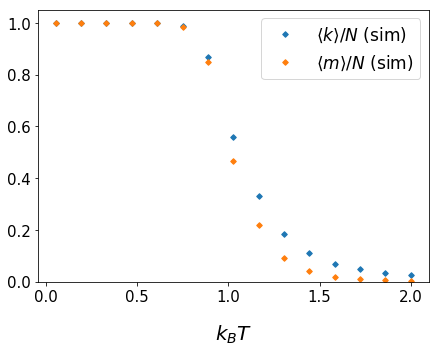

In [346]:
# Plot of simulation

plt.figure(figsize = (7,5))

# spectrum of temperature values
temp_vals1 = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals1))
mvals = np.ones(len(temp_vals1))

# plot of simulations
plt.plot(temp_vals, np.array(sim_kvals_1)/Np1,'D', label = r'$\langle k \rangle/N$ (sim)',  markersize = 4.0, )
plt.plot(temp_vals, np.array(sim_mvals_1)/Np1, 'D', label = r'$\langle m \rangle/N$ (sim)', markersize = 4.0, )

# plot design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.legend(loc = 'best', fontsize = 17)

warnings.simplefilter("ignore")

plt.show()

#### Simulation for Type II

In [244]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps

t0 = time.time()

# number of steps for MC algortihm
Nmc = 30000

# physical parameters
Np1 =  50 # Half of number of particles in system
E01 =14.00
Del = 3.45
Ev1 = 10**(-3)

# list of possible correct contacts (irrespective of order)
corr_list = [0]*(2*Np1)
for k in range(Np1):
    corr_list[k] = [k+1,Np1+k+1]
    corr_list[k+Np1] = [Np1+k+1, k+1]

# initial monomer and dimer states; 
# system in microstate of all correct dimers
mon_state_0 = []
dim_state_0 = corr_list[:Np1]

#mon_state_0 =list(range(1,2*Np1+1))
#dim_state_0 = []

npoints = 15 #number of temperature values
navg = 50 # number of times we run simulation at each temperature
temp_vals = np.linspace(.055, 2.0, npoints).tolist()

# list of dimer values and stdev
sim_kvals_2 = [0]*npoints

# list of correct dimer values and stdev
sim_mvals_2 = [0]*npoints

for k in range(npoints):
    
    fin_kvals_2 = [0]*navg
    fin_mvals_2 = [0]*navg
    
    for j in range(navg): 
        
        # make copy of initial monomer and dimer states 
        mon_copy = copy.deepcopy(mon_state_0)
        dim_copy = copy.deepcopy(dim_state_0)

        # metroplois generator
        mon_state_list, dim_state_list, accepted = meth_dimer(Niter = Nmc, 
                                                             dim_init = dim_copy,
                                                             mon_init = mon_copy, 
                                                             Np = Np1, 
                                                             temp = temp_vals[k], 
                                                             E0 = E01, 
                                                             Delta = Del, 
                                                             Ev = Ev1)
        fin_kvals_2[j] = avg_k(dim_state_list, Nmc)
        fin_mvals_2[j] = avg_m(dim_state_list, Nmc, Np1)
    
    
    sim_kvals_2[k] = np.mean(np.array(fin_kvals_2))
    sim_mvals_2[k] = np.mean(np.array(fin_mvals_2))
    
    t_prelim = time.time()
    print("Temperature Run:",str(k+1),"; Current Time:", round(t_prelim-t0,2),"secs")
    

t1 = time.time()
print("Total Simulation Run Time:",t1-t0,"secs")

Temperature Run: 1 ; Current Time: 1089.75 secs
Temperature Run: 2 ; Current Time: 2136.63 secs
Temperature Run: 3 ; Current Time: 3179.41 secs
Temperature Run: 4 ; Current Time: 4232.99 secs
Temperature Run: 5 ; Current Time: 5303.75 secs
Temperature Run: 6 ; Current Time: 6389.4 secs
Temperature Run: 7 ; Current Time: 7526.97 secs
Temperature Run: 8 ; Current Time: 8914.36 secs
Temperature Run: 9 ; Current Time: 10576.34 secs
Temperature Run: 10 ; Current Time: 12217.68 secs
Temperature Run: 11 ; Current Time: 13991.74 secs
Temperature Run: 12 ; Current Time: 15536.67 secs
Temperature Run: 13 ; Current Time: 17024.86 secs
Temperature Run: 14 ; Current Time: 18438.62 secs
Temperature Run: 15 ; Current Time: 19760.68 secs
Total Simulation Run Time: 19760.685429096222 secs


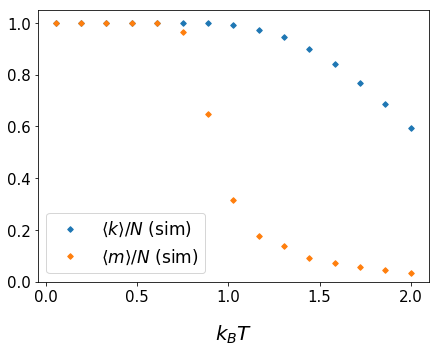

In [347]:
# Plot of simulation

plt.figure(figsize = (7,5))

# physical parameters
E0 =14.00
Del = 3.45
Ev = 0.001
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0


# spectrum of temperature values
temp_vals1 = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals1))
mvals = np.ones(len(temp_vals1))


# plot of simulations
plt.plot(temp_vals, np.array(sim_kvals_2)/Np1,'D', label = r'$\langle k \rangle/N$ (sim)',  markersize = 4.0, )
plt.plot(temp_vals, np.array(sim_mvals_2)/Np1, 'D', label = r'$\langle m \rangle/N$ (sim)', markersize = 4.0, )


# plot design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.legend(loc = 'best', fontsize = 17)

warnings.simplefilter("ignore")

plt.show()

#### Simulation for in between Type I and Type II

In [340]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps

t0 = time.time()

# number of steps for MC algortihm
Nmc = 30000

# physical parameters
Np1 =  50 # Half of number of particles in system
E01 =9.05
Del =4.65
Ev1 = 10**(-3)

# list of possible correct contacts (irrespective of order)
corr_list = [0]*(2*Np1)
for k in range(Np1):
    corr_list[k] = [k+1,Np1+k+1]
    corr_list[k+Np1] = [Np1+k+1, k+1]

# initial monomer and dimer states; 
# system in microstate of all correct dimers
mon_state_0 = []
dim_state_0 = corr_list[:Np1]

npoints = 15 #number of temperature values
navg = 50 # number of times we run simulation at each temperature
temp_vals = np.linspace(.055, 2.0, npoints).tolist()

# list of dimer values 
sim_kvals_3 = [0]*npoints

# list of correct dimer values 
sim_mvals_3 = [0]*npoints

for k in range(npoints):
    
    fin_kvals_3 = [0]*navg
    fin_mvals_3 = [0]*navg
    
    for j in range(navg): 
        
        # make copy of initial monomer and dimer states 
        mon_copy = copy.deepcopy(mon_state_0)
        dim_copy = copy.deepcopy(dim_state_0)

        # metroplois generator
        mon_state_list, dim_state_list, accepted = meth_dimer(Niter = Nmc, 
                                                             dim_init = dim_copy,
                                                             mon_init = mon_copy, 
                                                             Np = Np1, 
                                                             temp = temp_vals[k], 
                                                             E0 = E01, 
                                                             Delta = Del, 
                                                             Ev = Ev1)
        fin_kvals_3[j] = avg_k(dim_state_list, Nmc)
        fin_mvals_3[j] = avg_m(dim_state_list, Nmc, Np1)
    
    
    sim_kvals_3[k] = np.mean(np.array(fin_kvals_3))
    sim_mvals_3[k] = np.mean(np.array(fin_mvals_3))
    
    t_prelim = time.time()
    print("Temperature Run:",str(k+1),"; Current Time:", round(t_prelim-t0,2),"secs")
    

t1 = time.time()
print("Total Simulation Run Time:",t1-t0,"secs")

Temperature Run: 1 ; Current Time: 1072.42 secs
Temperature Run: 2 ; Current Time: 2072.82 secs
Temperature Run: 3 ; Current Time: 3098.34 secs
Temperature Run: 4 ; Current Time: 4120.98 secs
Temperature Run: 5 ; Current Time: 5148.4 secs
Temperature Run: 6 ; Current Time: 6215.37 secs
Temperature Run: 7 ; Current Time: 7286.52 secs
Temperature Run: 8 ; Current Time: 8653.09 secs
Temperature Run: 9 ; Current Time: 9982.97 secs
Temperature Run: 10 ; Current Time: 11285.83 secs
Temperature Run: 11 ; Current Time: 12534.22 secs
Temperature Run: 12 ; Current Time: 13624.58 secs
Temperature Run: 13 ; Current Time: 14604.8 secs
Temperature Run: 14 ; Current Time: 15461.45 secs
Temperature Run: 15 ; Current Time: 16251.55 secs
Total Simulation Run Time: 16251.547140836716 secs


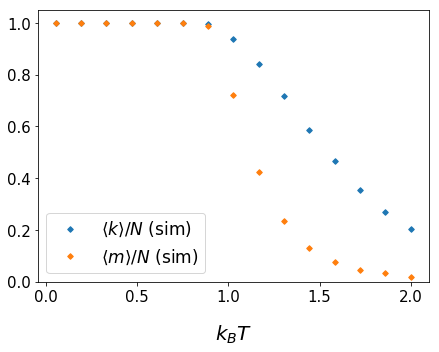

In [348]:
# Plot of simulation

plt.figure(figsize = (7,5))

# spectrum of temperature values
temp_vals1 = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals1))
mvals = np.ones(len(temp_vals1))

# plot of simulations
plt.plot(temp_vals, np.array(sim_kvals_3)/Np1,'D', label = r'$\langle k \rangle/N$ (sim)',  markersize = 4.0, )
plt.plot(temp_vals, np.array(sim_mvals_3)/Np1, 'D', label = r'$\langle m \rangle/N$ (sim)', markersize = 4.0, )

# plot design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.legend(loc = 'best', fontsize = 17)

warnings.simplefilter("ignore")

plt.show()

## IV. Solutions and Simulations Together 

#### First plot; Type I example

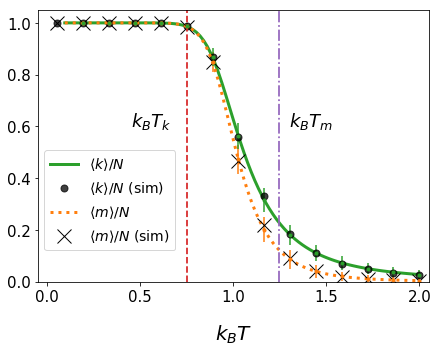

kBT_k = 0.7526113728
kBT_m = 1.24859663547


In [349]:
## Plot of a <k> and <m> for a Type I dimer system

plt.figure(figsize = (7,5))

# physical parameters
E0 =4.15
Del =5.75
Ev = 10**(-3)
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0

# spectrum of temperature, k, and m values
temp_vals = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals))
mvals = np.ones(len(temp_vals))

for k in range(len(temp_vals)):
    mvals[k], kvals[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals[k], E0,Del, Ev, Nelem))

# spectrum of temperature values; and k and m errors
temp_vals_err = np.linspace(Tmin, Tmax, 15)
kvals_err = np.ones(len(temp_vals_err))
mvals_err = np.ones(len(temp_vals_err))

for k in range(len(temp_vals_err)):
    mvals_err[k], kvals_err[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals_err[k], E0,Del, Ev, Nelem))
    
#plot of k and m versus T; error bars
plt.errorbar(temp_vals_err[1:], mvals_err[1:]/Nelem, color = 'C1', fmt = '.', yerr = sigma_m(kvals_err[1:], mvals_err[1:], Nelem)/Nelem)
plt.errorbar(temp_vals_err[1:], kvals_err[1:]/Nelem, color = 'C2', fmt = '.', yerr = sigma_k(kvals_err[1:], Nelem)/Nelem)

# temperature for simulation results
temp_vals0 = np.linspace(.055, 2.0, 15).tolist()

# main plot and simulation
plt.plot(temp_vals[2:], kvals[2:]/Nelem, color = 'C2', linestyle='solid', label = r'$\langle k \rangle/N$', linewidth = 3.0)
plt.plot(temp_vals0, np.array(sim_kvals_1)/Np1,color = 'black', marker = 'o',
         linestyle='None', label = r'$\langle k \rangle/N$ (sim)',
         markersize = 7.0, alpha = 0.75)
plt.plot(temp_vals[2:], mvals[2:]/Nelem, color = 'C1', linestyle='dotted', label = r'$\langle m \rangle/N$', linewidth = 3.0)
plt.plot(temp_vals0, np.array(sim_mvals_1)/Np1, color = 'black', marker = 'x',
         linestyle='None', label = r'$\langle m \rangle/N$ (sim)', 
         markersize = 14.0, alpha = 1.0)

# plot of critical temperatures
plt.axvline(x= kbTk(E0, Del, Ev, Nelem).real, color = 'C3', linestyle='dashed', linewidth = 1.75)
plt.axvline(x= Del/np.log(2*Nelem), color = 'C4', linestyle='-.', linewidth = 1.75)


# path design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.set_xlim([-.05,2.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)

ax.text(0.45, 0.6, r'$k_BT_k$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))
ax.text(1.3, 0.6, r'$k_BT_m$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (.37,0.51), fontsize = 14)

warnings.simplefilter("ignore")

plt.savefig("./typeIplot_wsim2.png", bbox_inches='tight')

plt.show()

#temperatures T_k and T_m 
print("kBT_k =", kbTk(E0, Del, Ev, Nelem).real)
print("kBT_m =",Del/np.log(2*Nelem))

------

#### Second Plot; Type II example

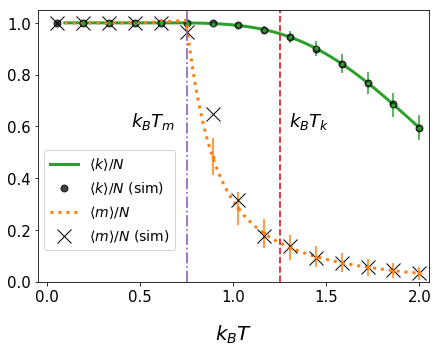

kBT_k = 1.25363030807
kBT_m = 0.749157981283


In [350]:
## Plot of a <k> and <m> for a Type II dimer system

plt.figure(figsize = (7,5))

# physical parameters
E0 =14.00
Del = 3.45
Ev = 0.001
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0


# spectrum of temperature values
temp_vals = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals))
mvals = np.ones(len(temp_vals))

# generating valus of m and k
for k in range(len(temp_vals)):
    
    mvals[k], kvals[k]  = fsolve(myfunc, [4.0, 4.0], args = (temp_vals[k], E0,Del, Ev, Nelem))


# spectrum of temperature values; and k and m errors
temp_vals_err = np.linspace(Tmin, Tmax, 15)
kvals_err = np.ones(len(temp_vals_err))
mvals_err = np.ones(len(temp_vals_err))

for k in range(len(temp_vals_err)):
    mvals_err[k], kvals_err[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals_err[k], E0,Del, Ev, Nelem))

#plot of k and m versus T; errors
plt.errorbar(temp_vals_err[1:], mvals_err[1:]/Nelem, color = 'C1', fmt = '.', yerr = sigma_m(kvals_err[1:], mvals_err[1:], Nelem)/Nelem)
plt.errorbar(temp_vals_err[1:], kvals_err[1:]/Nelem, color = 'C2', fmt = '.', yerr = sigma_k(kvals_err[1:], Nelem)/Nelem)

# temperature for simulation results
temp_vals0 = np.linspace(.055, 2.0, 15).tolist()

# main plot and simulation
plt.plot(temp_vals[2:], kvals[2:]/Nelem, color = 'C2', linestyle='solid', label = r'$\langle k \rangle/N$', linewidth = 3.0)
plt.plot(temp_vals0, np.array(sim_kvals_2)/Np1,color = 'black', marker = 'o',
         linestyle='None', label = r'$\langle k \rangle/N$ (sim)',
         markersize = 7.0, alpha = 0.75)
plt.plot(temp_vals[2:], mvals[2:]/Nelem, color = 'C1', linestyle='dotted', label = r'$\langle m \rangle/N$', linewidth = 3.0)
plt.plot(temp_vals0, np.array(sim_mvals_2)/Np1, color = 'black', marker = 'x',
         linestyle='None', label = r'$\langle m \rangle/N$ (sim)', 
         markersize = 14.0, alpha = 1.0)


# plot of critical temperatures
plt.axvline(x= kbTk(E0, Del, Ev, Nelem).real, color = 'C3', linestyle='dashed', linewidth = 1.75)
plt.axvline(x= Del/np.log(2*Nelem), color = 'C4', linestyle='-.', linewidth = 1.75)


# path design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0.0,1.05])
ax.set_xlim([-.05,2.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)

ax.text(0.45, 0.6, r'$k_BT_m$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))
ax.text(1.3, 0.6, r'$k_BT_k$', color='black', fontsize = 18,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (.37,.51), fontsize = 14)

warnings.simplefilter("ignore")

plt.savefig("./typeIIplot_wsim2.png", bbox_inches='tight')


plt.show()

#temperatures T_k and T_m 
print("kBT_k =", kbTk(E0, Del, Ev, Nelem).real)
print("kBT_m =",Del/np.log(2*Nelem))

------

#### Third Plot; Between Type I and Type II example

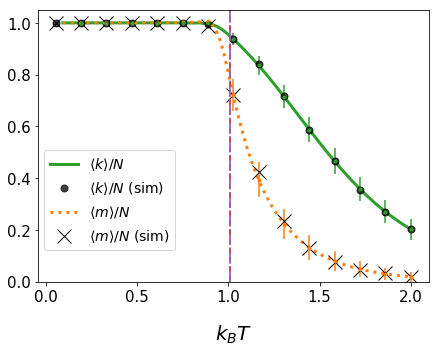

kBT_k = 1.00792044435
kBT_m = 1.00973467043


In [351]:
##  Plot of a <k> and <m> for system intermediate between Types I and II dimer system

plt.figure(figsize = (7,5))

# physical parameters
E0 =9.05
Del =4.65
Ev = 10**(-3)
Nelem = 50

# temperature limits
Tmin = .055
Tmax = 2.0

# spectrum of temperature values
temp_vals = np.linspace(Tmin, Tmax, 100)
kvals = np.ones(len(temp_vals))
mvals = np.ones(len(temp_vals))

# generating valus of m and k
for k in range(len(temp_vals)):

    mvals[k], kvals[k]  = fsolve(myfunc, [.5, 1.0], args = (temp_vals[k], E0,Del, Ev, Nelem))

# spectrum of temperature values; and k and m errors
temp_vals_err = np.linspace(Tmin, Tmax, 15)
kvals_err = np.ones(len(temp_vals_err))
mvals_err = np.ones(len(temp_vals_err))

for k in range(len(temp_vals_err)):
    mvals_err[k], kvals_err[k]  = fsolve(myfunc, [.05, 1.0], args = (temp_vals_err[k], E0,Del, Ev, Nelem))

#plot of k and m versus T; errors
plt.errorbar(temp_vals_err[1:], mvals_err[1:]/Nelem, color = 'C1', fmt = '.', yerr = sigma_m(kvals_err[1:], mvals_err[1:], Nelem)/Nelem)
plt.errorbar(temp_vals_err[1:], kvals_err[1:]/Nelem, color = 'C2', fmt = '.', yerr = sigma_k(kvals_err[1:], Nelem)/Nelem)

# temperature for simulation results
temp_vals0 = np.linspace(.055, 2.0, 15).tolist()

# main plot and simulation
plt.plot(temp_vals[2:], kvals[2:]/Nelem, color = 'C2', linestyle='solid', label = r'$\langle k \rangle/N$', linewidth = 3.0)
plt.plot(temp_vals0, np.array(sim_kvals_3)/Np1,color = 'black', marker = 'o',
         linestyle='None', label = r'$\langle k \rangle/N$ (sim)',
         markersize = 7.0, alpha = 0.75)
plt.plot(temp_vals[2:], mvals[2:]/Nelem, color = 'C1', linestyle='dotted', label = r'$\langle m \rangle/N$', linewidth = 3.0)
plt.plot(temp_vals0, np.array(sim_mvals_3)/Np1, color = 'black', marker = 'x',
         linestyle='None', label = r'$\langle m \rangle/N$ (sim)', 
         markersize = 14.0, alpha = 1.0)


# plot of critical temperatures
plt.axvline(x= kbTk(E0, Del, Ev, Nelem), color = 'C3', linestyle='dashed', linewidth = 1.75)
plt.axvline(x= Del/np.log(2*Nelem), color = 'C4', linestyle='-.', linewidth = 1.75)


# path design options
plt.xlabel(r'$k_B T$', fontsize = 20)
ax = plt.gca()
ax.set_ylim([0,1.05])
ax.yaxis.set_label_coords(-0.1,.5)
ax.xaxis.set_label_coords(.5,-.15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (.37,.51), fontsize = 14)

warnings.simplefilter("ignore")

plt.savefig("./typeIandIIplot_wsim2.png", bbox_inches='tight')

plt.show()

#temperatures T_k and T_m 
print("kBT_k =", kbTk(E0, Del, Ev, Nelem).real)
print("kBT_m =",Del/np.log(2*Nelem))

------